# Réduction de dimension par ACP

On souhaite diminuer la dimension des séries temporelles (à 4 bandes) pour qu'elles soient univariées pour chaque pixel.

In [2]:
from cookie_clusters import *

In [7]:
from sklearn.decomposition import PCA
import os
import itertools
from PIL import Image
import rasterio as rio
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# List of target pixels
pixels_de_interet, dic_de_pixels = create_dic_pixels()
len(pixels_de_interet)
pixels_de_interet
dic_de_pixels

{'pix_foret': [[472, 570],
  [474, 570],
  [476, 570],
  [478, 570],
  [480, 570],
  [482, 570],
  [484, 570],
  [486, 570],
  [488, 570]],
 'pix_lac': [[392, 567],
  [392, 580],
  [401, 577],
  [401, 567],
  [395, 570],
  [395, 576],
  [397, 571],
  [394, 598],
  [388, 532]],
 'pix_apt': [[405, 448],
  [408, 444],
  [412, 446],
  [412, 463],
  [407, 465],
  [405, 455],
  [414, 440],
  [420, 458],
  [401, 446]],
 'pix_ensta': [[447, 618],
  [454, 627],
  [454, 631],
  [457, 632],
  [459, 625],
  [450, 641],
  [443, 636],
  [439, 629],
  [433, 617]],
 'pix_agri': [[318, 438],
  [322, 435],
  [324, 433],
  [329, 429],
  [333, 426],
  [337, 424],
  [339, 422],
  [344, 418],
  [350, 414]],
 'pix_danone': [[383, 497],
  [383, 500],
  [387, 501],
  [383, 504],
  [387, 505],
  [384, 508],
  [388, 509],
  [384, 504],
  [386, 504]]}

In [8]:
# Pour le fil rouge
dir = "../../../images-fil-rouge"
images_list_original = [x for x in os.listdir(dir) if x.endswith(".tif")]
images_list_original.sort()
images_list_original.pop(21) # On enlève l'image 21 qui est une image erronée)

'crop_SENTINEL2A_20180210-105158-460_L2A_T31UDQ_C_V2-2.tif'

In [9]:
# Getting the pixel values for each image
nband = 4
images_list_beforePCA = np.zeros((len(images_list_original), len(pixels_de_interet), nband))
for image in images_list_original:
    matrice = np.zeros((len(pixels_de_interet),nband))
    with rio.open(dir+'/'+image, 'r') as ds:
        # arr = ds.read()
        band1 = ds.read(1)
        band2 = ds.read(2)            
        band3 = ds.read(3)
        band4 = ds.read(4)
        # Extraction of target pixels
    for pixel,j in zip(pixels_de_interet, range(len(pixels_de_interet))):
        matrice[j,0] = band1[pixel[0], pixel[1]]
        matrice[j,1] = band2[pixel[0], pixel[1]]
        matrice[j,2] = band3[pixel[0], pixel[1]]
        matrice[j,3] = band4[pixel[0], pixel[1]]
    images_list_beforePCA[images_list_original.index(image)] = matrice

In [10]:
# Reshaping to apply PCA
images_list_beforePCA.reshape((len(images_list_original)*len(pixels_de_interet),nband)).shape

# Applying PCA with 1 component
pca = PCA(n_components=1)
images_list_afterPCA = pca.fit_transform(images_list_beforePCA.reshape((len(images_list_original)*len(pixels_de_interet),nband)))
images_list_afterPCA = images_list_afterPCA.reshape((len(images_list_original), len(pixels_de_interet)))

In [11]:
# Reshaping into time series
TS_after_pca = images_list_afterPCA.T

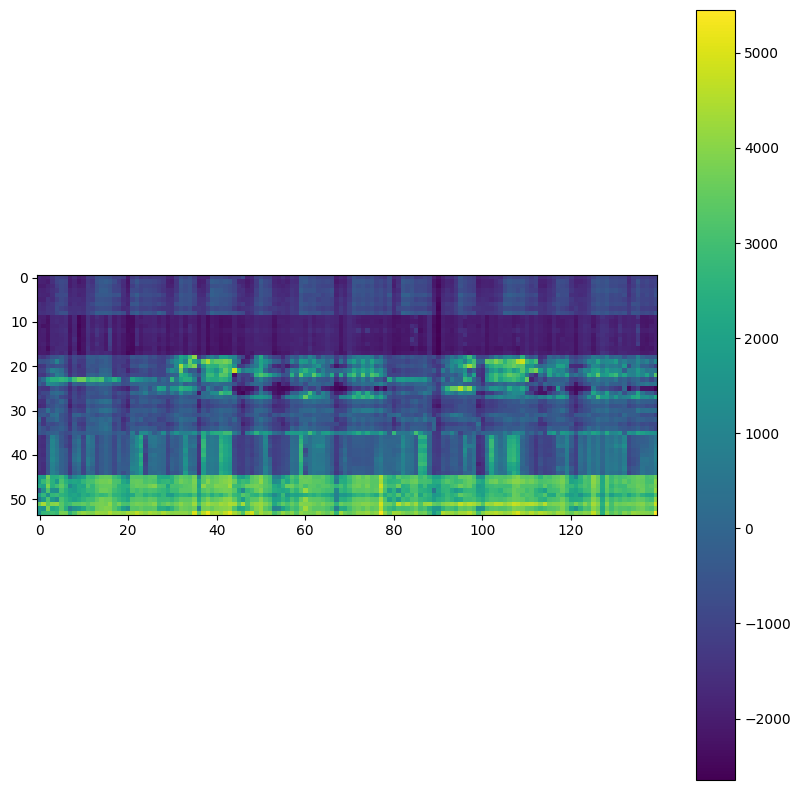

In [12]:
#Looking for a pixels
plt.figure(figsize=(10,10))
plt.imshow(TS_after_pca)
plt.colorbar()
plt.show()

## Clustering

In [13]:
from cookie_clusters import *

yhat = kmeans_dtw(TS_after_pca,6,5000)

,accuracy,f1_score
0,0.833333,0.819561


,calinski_harabasz_score
0,82.303714


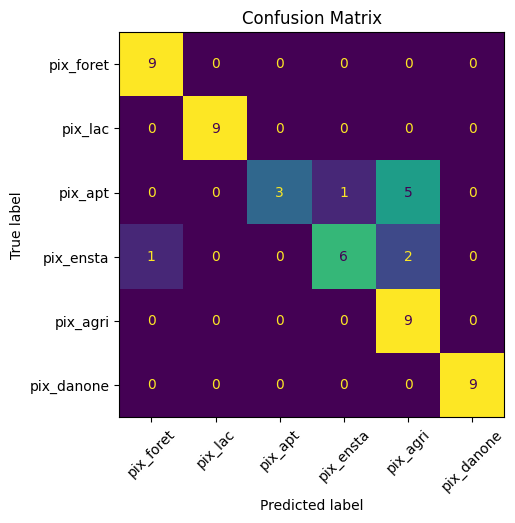

In [16]:
# from cookie_clusters import evaluator_de_experiences

eval_PCA = evaluator_de_experiences(yhat, pixels_de_interet, dic_de_pixels, TS_after_pca)
eval_PCA.confusion_matrix()
display(eval_PCA.metrics_classif())
display(eval_PCA.metrics_clustering())

In [18]:
eval_PCA.show_list()

cluster numero 0:
-------------------------------
[414, 440] : pix_apt
[454, 627] : pix_ensta
[457, 632] : pix_ensta
[459, 625] : pix_ensta
[450, 641] : pix_ensta
[443, 636] : pix_ensta
[439, 629] : pix_ensta
-------------------------------
cluster numero 1:
-------------------------------
[383, 497] : pix_danone
[383, 500] : pix_danone
[387, 501] : pix_danone
[383, 504] : pix_danone
[387, 505] : pix_danone
[384, 508] : pix_danone
[388, 509] : pix_danone
[384, 504] : pix_danone
[386, 504] : pix_danone
-------------------------------
cluster numero 2:
-------------------------------
[472, 570] : pix_foret
[474, 570] : pix_foret
[476, 570] : pix_foret
[478, 570] : pix_foret
[480, 570] : pix_foret
[482, 570] : pix_foret
[484, 570] : pix_foret
[486, 570] : pix_foret
[488, 570] : pix_foret
[454, 631] : pix_ensta
-------------------------------
cluster numero 3:
-------------------------------
[408, 444] : pix_apt
[412, 446] : pix_apt
[412, 463] : pix_apt
[407, 465] : pix_apt
[405, 455] : pi